In [11]:
# Cell 1: Import Libraries
import torch
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
from PIL import Image
import cv2

# Add src to path
sys.path.append('..')

from src.data import create_dataloaders, denormalize, get_transforms
from src.data.counterfactual_generation import create_counterfactual

print(f"PyTorch version: {torch.__version__}")
print(f"MPS available: {torch.backends.mps.is_available()}")


PyTorch version: 2.9.0
MPS available: True


In [12]:
data_root = os.path.expanduser('~/datasets/oxford-iiit-pet')

train_loader, val_loader, dataset = create_dataloaders(
    data_root=data_root,
    split_metadata_path='../data/processed/split_metadata.json',
    batch_size=32,
    num_workers=4,
    img_size=224,
    pin_memory=False
)


✓ Loaded split from ../data/processed/split_metadata.json
✓ Train dataset: 2944 samples
✓ Val dataset: 736 samples
✓ Train loader: 92 batches
✓ Val loader: 23 batches


In [13]:
# Cell 3: Test and Visualize (works now!)
batch = next(iter(train_loader))
print(f"✓ Batch loaded successfully")
print(f"  Image shape: {batch['image'].shape}")
print(f"  Mask shape: {batch['mask'].shape}")
print(f"  Original image shape: {batch['original_image'].shape}") 

train_dataset = train_loader.dataset
val_dataset = val_loader.dataset

print(f"✓ Train dataset: {len(train_dataset)} samples")
print(f"✓ Val dataset: {len(val_dataset)} samples")


✓ Batch loaded successfully
  Image shape: torch.Size([32, 3, 224, 224])
  Mask shape: torch.Size([32, 224, 224])
  Original image shape: torch.Size([32, 224, 224, 3])
✓ Train dataset: 2944 samples
✓ Val dataset: 736 samples


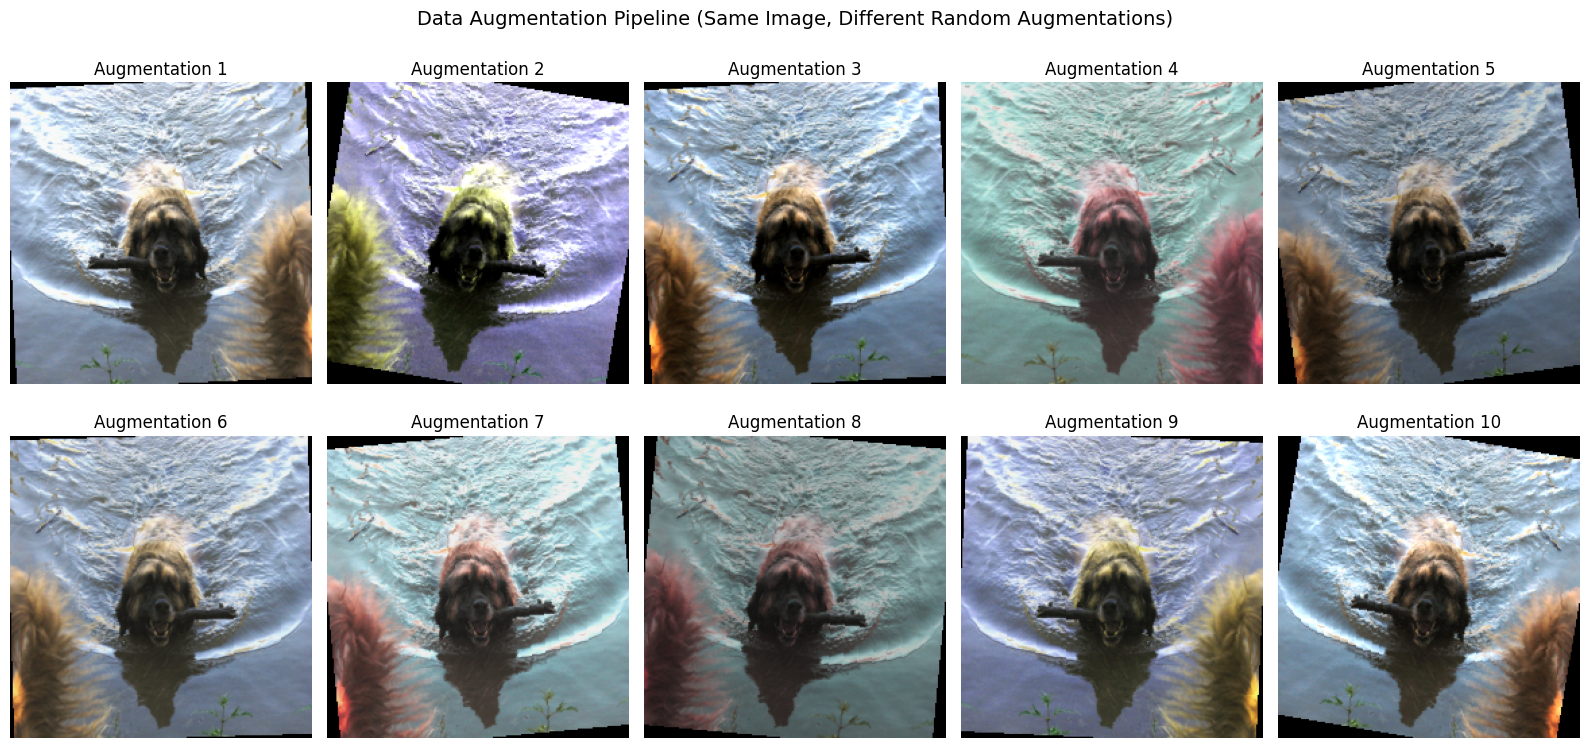

✓ Augmentation pipeline visualization saved


In [14]:
# Visualize augmentation effects on same image
fig, axes = plt.subplots(2, 5, figsize=(16, 8))

# Get one sample
sample = train_dataset[0]
original_image = Image.fromarray(sample['original_image'])

# Apply different augmentations multiple times
for i in range(10):
    # Apply training transform (with augmentation)
    train_aug_image = train_dataset.transform(original_image)
    
    # Denormalize for visualization
    aug_np = denormalize(train_aug_image).permute(1, 2, 0).numpy()
    
    row = i // 5
    col = i % 5
    axes[row, col].imshow(aug_np)
    axes[row, col].set_title(f'Augmentation {i+1}')
    axes[row, col].axis('off')

plt.suptitle('Data Augmentation Pipeline (Same Image, Different Random Augmentations)', fontsize=14)
plt.tight_layout()
os.makedirs('../experiments/results/visualizations', exist_ok=True)
plt.savefig('../experiments/results/visualizations/augmentation_pipeline.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Augmentation pipeline visualization saved")


In [15]:
import os
import glob
from PIL import Image

# Load background images once
BACKGROUND_DIR = '../data/backgrounds'
BACKGROUND_IMAGES = []

def load_background_images(background_dir=BACKGROUND_DIR):
    """Load all background images into memory"""
    global BACKGROUND_IMAGES
    
    if len(BACKGROUND_IMAGES) > 0:
        return BACKGROUND_IMAGES  # Already loaded
    
    bg_paths = sorted(glob.glob(os.path.join(background_dir, '*.jpg')) + 
                     glob.glob(os.path.join(background_dir, '*.png')))
    
    print(f"Loading {len(bg_paths)} background images...")
    
    for path in bg_paths:
        img = Image.open(path).convert('RGB')
        BACKGROUND_IMAGES.append(np.array(img))
    
    print(f"✓ Loaded {len(BACKGROUND_IMAGES)} background images")
    return BACKGROUND_IMAGES


def create_counterfactual_with_external_bg(fg_image, fg_mask, background_image=None, blend_sigma=5):
    """
    Create counterfactual using external background image
    
    Args:
        fg_image: Pet image (numpy array, uint8, HxWx3)
        fg_mask: Pet mask (1=pet, 0=background)
        background_image: External background (numpy array, uint8, HxWx3)
                         If None, will randomly select from loaded backgrounds
        blend_sigma: Gaussian blur sigma for smooth edges
    
    Returns:
        Counterfactual image with pet on external background
    """
    # Load backgrounds if not loaded
    if len(BACKGROUND_IMAGES) == 0:
        load_background_images()
    
    # Select random background if not provided
    if background_image is None:
        background_image = BACKGROUND_IMAGES[np.random.randint(0, len(BACKGROUND_IMAGES))]
    
    # Resize background to match foreground size
    h, w = fg_image.shape[:2]
    background_resized = cv2.resize(background_image, (w, h))
    
    # Ensure mask is 2D
    if fg_mask.ndim == 3:
        fg_mask = fg_mask[:, :, 0]
    
    # Convert mask to 3 channels
    fg_mask_3ch = np.stack([fg_mask, fg_mask, fg_mask], axis=-1)
    
    # Extract foreground pet
    foreground = fg_image * fg_mask_3ch
    
    # Use external background (inverted mask)
    background = background_resized * (1 - fg_mask_3ch)
    
    # Combine
    counterfactual = foreground + background
    
    # Smooth edges with Gaussian blur
    if blend_sigma > 0:
        kernel = np.ones((5, 5), np.uint8)
        fg_mask_uint8 = (fg_mask * 255).astype(np.uint8)
        
        # Dilate and erode to find edges
        edge_mask = cv2.dilate(fg_mask_uint8, kernel, iterations=2) - \
                   cv2.erode(fg_mask_uint8, kernel, iterations=2)
        edge_mask = edge_mask.astype(np.float32) / 255.0
        edge_mask_3ch = np.stack([edge_mask, edge_mask, edge_mask], axis=-1)
        
        # Apply Gaussian blur at edges
        blurred = cv2.GaussianBlur(counterfactual.astype(np.float32), (11, 11), blend_sigma)
        counterfactual = counterfactual * (1 - edge_mask_3ch) + blurred * edge_mask_3ch
    
    return counterfactual.astype(np.uint8)


print("✓ External background counterfactual generator defined")


✓ External background counterfactual generator defined


Loading 15 background images...
✓ Loaded 15 background images


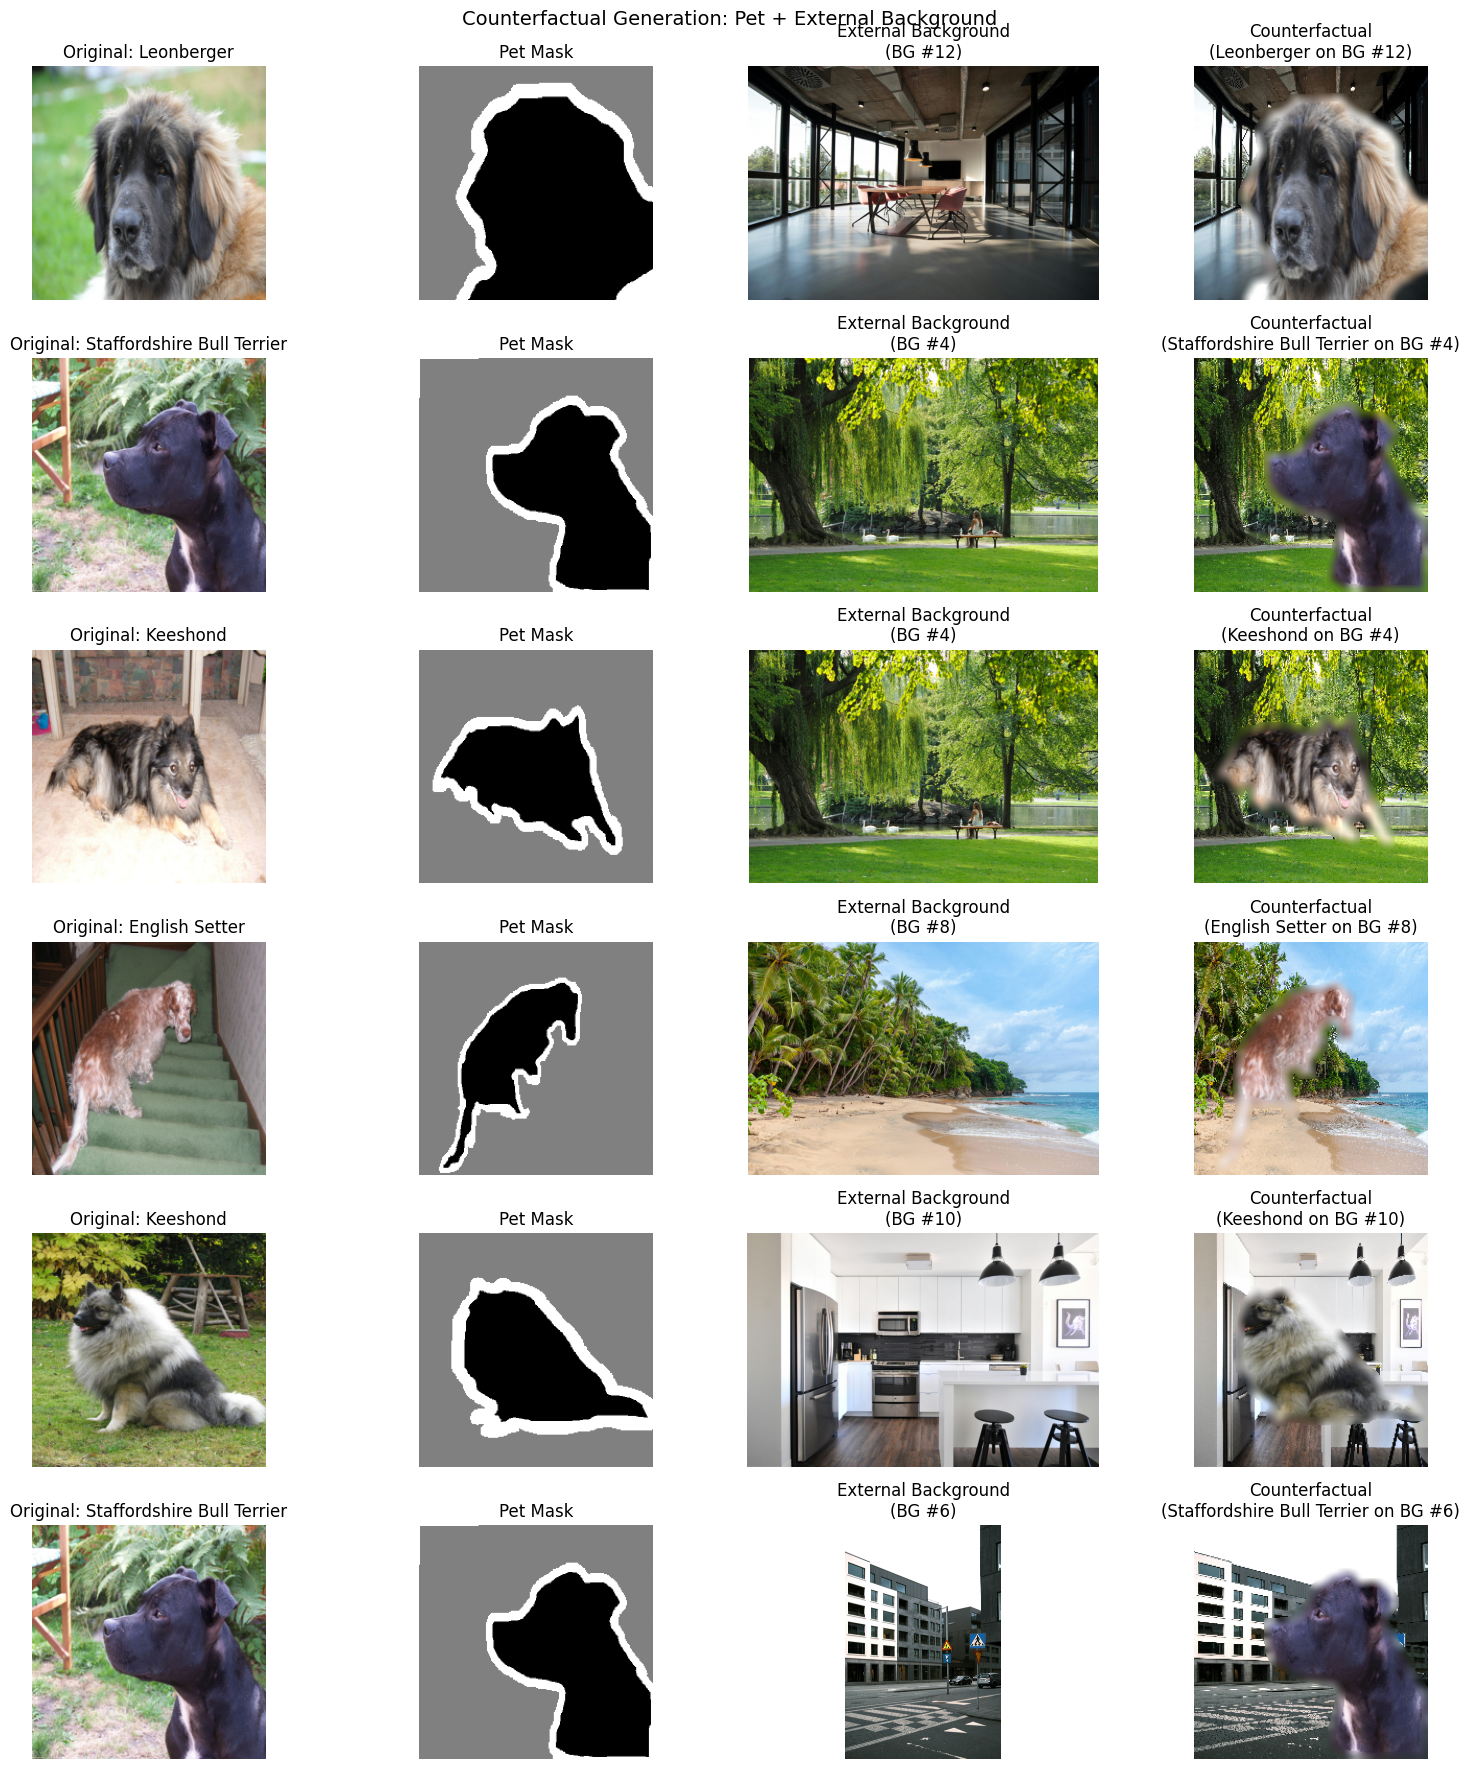

✓ Counterfactual with external backgrounds visualization saved


In [16]:
# Load background images first
load_background_images()

# Show counterfactuals with external backgrounds
fig, axes = plt.subplots(6, 4, figsize=(16, 18))

for idx in range(6):
    # Get one pet sample
    sample_idx = np.random.randint(0, len(val_dataset))
    sample = val_dataset[sample_idx]
    
    # Get random background
    bg_idx = np.random.randint(0, len(BACKGROUND_IMAGES))
    background = BACKGROUND_IMAGES[bg_idx]
    
    # Original pet image
    axes[idx, 0].imshow(sample['original_image'])
    class_name = dataset.classes[sample['label']]
    axes[idx, 0].set_title(f'Original: {class_name}')
    axes[idx, 0].axis('off')
    
    # Pet mask
    axes[idx, 1].imshow(sample['original_mask'], cmap='gray')
    axes[idx, 1].set_title('Pet Mask')
    axes[idx, 1].axis('off')
    
    # External background (before adding pet)
    axes[idx, 2].imshow(background)
    axes[idx, 2].set_title(f'External Background\n(BG #{bg_idx})')
    axes[idx, 2].axis('off')
    
    # Counterfactual with external background
    fg_img = sample['original_image']
    fg_mask = (sample['original_mask'] == 1).astype(np.float32)
    
    counterfactual = create_counterfactual_with_external_bg(fg_img, fg_mask, background)
    axes[idx, 3].imshow(counterfactual)
    axes[idx, 3].set_title(f'Counterfactual\n({class_name} on BG #{bg_idx})')
    axes[idx, 3].axis('off')

plt.suptitle('Counterfactual Generation: Pet + External Background', fontsize=14)
plt.tight_layout()
os.makedirs('../experiments/results/visualizations', exist_ok=True)
plt.savefig('../experiments/results/visualizations/counterfactual_external_bg.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Counterfactual with external backgrounds visualization saved")


In [19]:
from tqdm import tqdm
import json
# Generate counterfactuals for entire validation set using external backgrounds
print("Generating counterfactuals with external backgrounds for validation set...")

load_background_images()  # Ensure backgrounds are loaded

counterfactual_metadata = []
os.makedirs('../data/counterfactuals/val_counterfactual/images', exist_ok=True)

for i in tqdm(range(len(val_dataset))):
    sample = val_dataset[i]
    
    # Randomly select background
    bg_idx = np.random.randint(0, len(BACKGROUND_IMAGES))
    background = BACKGROUND_IMAGES[bg_idx]
    
    # Get pet and mask
    fg_img = sample['original_image']
    fg_mask = (sample['original_mask'] == 1).astype(np.float32)
    
    # Create counterfactual
    counterfactual = create_counterfactual_with_external_bg(fg_img, fg_mask, background)
    
    # Save
    cf_filename = f"counterfactual_{i:04d}.jpg"
    cf_path = f'../data/counterfactuals/val_counterfactual/images/{cf_filename}'
    Image.fromarray(counterfactual).save(cf_path)
    
    # Save metadata
    counterfactual_metadata.append({
        'index': i,
        'original_idx': sample['index'],
        'background_type': 'external',
        'background_idx': bg_idx,
        'label': sample['label'],
        'counterfactual_path': cf_path
    })

# Save metadata
with open('../data/counterfactuals/val_counterfactual/metadata.json', 'w') as f:
    json.dump(counterfactual_metadata, f, indent=2)

print(f"✓ Generated {len(counterfactual_metadata)} counterfactuals with external backgrounds")
print(f"  Images: ../data/counterfactuals/val_counterfactual/images/")
print(f"  Metadata: ../data/counterfactuals/val_counterfactual/metadata.json")


Generating counterfactuals with external backgrounds for validation set...


100%|██████████████████████████████████████████████████████████████████| 736/736 [00:03<00:00, 187.77it/s]

✓ Generated 736 counterfactuals with external backgrounds
  Images: ../data/counterfactuals/val_counterfactual/images/
  Metadata: ../data/counterfactuals/val_counterfactual/metadata.json
